Задача: разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.  

Цели: 

Подготовить данные, выбрав наиболее важные и очистив от мусорных данных.

Настроить модель для обучения.

Запустить сервис

Подготовка данных:

1) Убрать лишние столбцы 'status', 'private pool', 'propertytype', 'street', 'city', 'zipcode', 'stories', 'mls-id', 'mlsid'

2) Заменить буквенные значения на цифры: Для privatepool и fireplace 1 и 0; в поле target убрать знак $, для beds и baths оставить только значения, все штаты заменить соответствующими цифрами 

3)найти max(год постройки\ремонта)

4)отметить наличие парковки,кондиционера, системы отопления

In [ ]:
import pandas as pd
import math
import numpy as np
import re
sample = pd.read_csv("data.csv")
sample.columns = [item.lower() for item in sample.columns]
sample.drop_duplicates()
sample = sample.drop(['status', 'private pool', 'propertytype', 'street', 'city', 'zipcode', 'stories', 'mls-id'], axis=1)
sample = sample.drop(['mlsid'], axis=1)
w = sample.copy(deep='True')
w["privatepool"].fillna("0", inplace = True)
w = w.replace(to_replace ="yes", value ="1")
w = w.replace(to_replace ="Yes", value ="1")
w = w.dropna(subset=['target'])
w = w.dropna(subset=['sqft'])
w.loc[w['fireplace'] == np.nan, 'fireplace'] = 0
w1 = w.copy(deep='True')
w1['fireplace'] = w1['fireplace'].fillna(0)
w1.loc[w1['fireplace'] != 0, 'fireplace'] = 1
region_dictionary = {'NC' : 1, 'WA' : 2, 'CA' : 3, 'TX' : 4, 'FL' : 5, 'PA' : 6, 'TN' : 7, 'IA' : 8, 'NY' : 9, 'OR' : 10, 'DC' : 11,
       'NV' : 12, 'AZ' : 13, 'GA' : 14, 'IL' : 15, 'NJ' : 16, 'MA' : 17, 'OH' : 18, 'IN' : 19, 'UT' : 20, 'MI' : 21, 'VT' : 22,
       'MD' : 23, 'CO' : 24, 'VA' : 25, 'KY' : 26, 'MO' : 27, 'WI' : 28, 'ME' : 29, 'MS' : 30, 'OK' : 31, 'SC' : 32, 'MT' : 33,
       'DE' : 34, 'Fl' : 35, 'BA' : 36, 'AL' : 37, 'OT' : 38, 'OS' : 39}
w1['state'] = w1['state'].apply(lambda x: region_dictionary[x])
w2 = w1.copy(deep='True')
w2['beds'] = w2['beds'].fillna(9999)
w2 = w2.drop(['baths'], axis=1)
w2 = w2.reset_index(drop=True)
w3 = w2.copy(deep='True')
w3["year"] = "1000"
w3["heating"] = "0"
w3["cooling"] = "0"
w3["parking"] = "0"

In [ ]:
# цена дома
for i in range (0,334582):
    w3.iloc[i,7] = re.sub('\$', '', str(w3.iloc[i,7]))
    w3.iloc[i,7] = re.sub(',', '', str(w3.iloc[i,7]))
    if re.match('(\d+)', str(w3.iloc[i][7])) == None:
        w3.iloc[i,7] = 600000
    w3.iloc[i,7] = re.match('(\d+)', str(w3.iloc[i][7])).group(0)
print('записал цену дома')
# размер дома
for i in range (0,334582):
    if re.match('(\d+)', str(w3.iloc[i][3])) == None:
        w3.iloc[i,3] = 1500
    w3.iloc[i,3] = re.sub(',', '', str(w3.iloc[i,3]))
    w3.iloc[i,3] = re.match('(\d+)', str(w3.iloc[i][3])).group(0)
print('записал размер дома')
# кол-во спален
for i in range (0,334582):
    if re.match('(\d+)', str(w3.iloc[i][4])) == None:
        w3.iloc[i,4] = 9999
    w3.iloc[i,4] = re.match('(\d+)', str(w3.iloc[i][4])).group(0)
print('записал кол-во спален дома')
# средний рейтинг школ
for i in range (0,334582):
    index = str(w3['schools'][i]).find(']')
    a = w3['schools'][i][0:index]
    b = re.findall('(\d+)', a)
    c = 0
    for j in b:
        c += int(j) * int(j)
    if len(b) == 0:
        kekw = 18
    else:
        kekw = c//len(b)
    w3.iloc[i,2] = kekw
print('записал рейт школ дома')
# Мах(Год постройки, ремонт дома), есть ли обогрев, кондиционер, парковка
for index,row in w3.iterrows():
    a = 0
    if re.search('(\d+)', row['homefacts'][50:120]) == None:
        if re.search('(\d+)', row['homefacts'][0:50]) == None:
            w3.iloc[index,9] = 99999
            continue
        if int(re.search('(\d+)', row['homefacts'][0:50]).group(0)) < 2000:
            w3.iloc[index,9] = 99999
            continue
        a = re.search('(\d+)', row['homefacts'][0:50]).group(0)
    else:
        a = re.search('(\d+)', row['homefacts'][50:120]).group(0)
    w3.iloc[index,9] = a
    a = row['homefacts'].find("Heating")
    b = row['homefacts'][0:a].rfind("{")
    if a - b > 33:
        w3.iloc[index,10] = 1
    a = row['homefacts'].find("Cooling")
    b = row['homefacts'][0:a].rfind("{")
    if a - b > 33:
        w3.iloc[index,11] = 1
    a = row['homefacts'].find("Parking")
    b = row['homefacts'][0:a].rfind("{")
    if a - b > 33:
        w3.iloc[index,12] = 1
w3 = w3.reset_index(drop=True)


Удаление лишних данных

In [ ]:
for index, row in w3.iterrows():
    if index % 1000 ==0:
        print(index)
    if row['sqft'] < 800 or row['sqft'] > 7000:
        w3.drop([index], inplace=True)
        continue
    if row['beds'] > 10:
        w3.drop([index], inplace=True)
        continue
    if row['baths'] > 10:
        w3.drop([index], inplace=True)
        continue
    if row['year'] < 1900 or row['year'] > 2019:
        w3.drop([index], inplace=True)
        continue
    if row['target'] < 10000 or row['target'] > 4000000:
        w3.drop([index], inplace=True)
        continue
    if row['schools'] > 100:
        w3.drop([index], inplace=True)
        continue

В итоге полученный csv файл ITOG.csv

In [3]:
import pandas as pd
import math
import numpy as np
import re
df = pd.read_csv("ITOG.csv")
del df['Unnamed: 0']

In [4]:
df

,baths,fireplace,schools,sqft,beds,state,privatepool,target,year,heating,cooling,parking
0,3,1,29,2900,4,1,0,418000,2019,1,0,0
1,3,0,66,1947,3,2,0,310000,2019,0,0,0
2,2,1,74,3000,3,3,1,2895000,1967,1,1,1
3,8,1,92,6457,5,4,0,2395000,2006,1,1,1
4,3,0,54,1930,3,4,0,311995,2019,1,1,1
5,3,0,77,2839,4,5,1,525000,1997,1,1,1
6,3,0,65,2454,4,4,0,168800,1982,1,1,1
7,4,1,74,3080,4,4,0,365000,2016,1,1,1
8,4,1,84,3645,4,4,0,499007,2019,1,1,1
9,2,1,63,1953,4,4,0,182000,2014,1,1,1


Из 377186 строк осталось 139892, что вполне достаточно для обучения.

Настройка модели

In [5]:
X = df[['baths','fireplace','schools','sqft','beds','state','privatepool','year','heating','cooling', 'parking']]
Y = df['target']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Создана рабочая модель линейной регрессии.

In [7]:
y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

Linear Regression R squared": 0.3804


Линейная регрессия R в квадрате: 0,3804

Рассчет среднеквадратичной ошибки (RMSE) 

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 423038.9605


Наша модель смогла предсказать стоимость каждого дома в тестовом наборе в пределах $ 423038 от реальной цены.

Рассчет средней абсолютной ошибки (MAE):

In [9]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_pred, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)

Linear Regression MAE: 267486.6384


Случайный Лес

In [10]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42, n_estimators=100)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [11]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.6840


Случайный Лес R в квадрате: 0,6840

In [12]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 302110.6230


Наша модель смогла предсказать стоимость каждого дома в тестовом наборе в пределах $ 302110 от реальной цены.

In [18]:
lin_mae = mean_absolute_error(y_pred, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)

Linear Regression MAE: 203141.8397


Gradient Boosting

In [13]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.5644


In [15]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 354708.6217


Случайный лес показывает лучшие результаты, так что это наша окончательная модель.

Давайте выясним, какие переменные важны, и наоборот в случайном лесе.

In [16]:
feature_labels = np.array(['baths','fireplace','schools','sqft','beds','state','privatepool','year','heating','cooling', 'parking'])
importance = forest_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

cooling-0.67%
parking-1.05%
heating-1.22%
fireplace-1.36%
privatepool-1.76%
beds-4.60%
schools-11.97%
year-12.01%
state-15.73%
sqft-21.06%
baths-28.57%


По итогу удалось добиться 68,4% точности, что неплохо.

Наиболее важными являются: кол-во ванных, площадь, штат, год и рейтинг школ. В целом, все переменные используются для предсказания цены.

После этого данная модель была сохранена при помощи Pickle и использовалась в дальнейшем сервисе.

In [ ]:
import pickle
with open('myfile.pkl', 'wb') as output:
       pickle.dump(forest_reg, output)

После этого создан сервис - страницы, в которую вводятся данные и предсказывается примерная цена дома.

In [ ]:
#file site.py
from http.server import HTTPServer, CGIHTTPRequestHandler
server_address = ("", 8000)
httpd = HTTPServer(server_address, CGIHTTPRequestHandler)
httpd.serve_forever()

In [ ]:
#file index.html
<!DOCTYPE HTML>
<html>
<head>
<meta charset="utf-8">
<title>Обработка данных форм</title>
</head>
<body>
    <form action="/cgi-bin/form.py">
        <h1>Оценка дома</h1>
        <h4>Введите количество ванных комнат (0-10)</h4> <input type="text" name="a1">
        <br>
        <h4>Имеется ли камин?(0,1)</h4> <input type="text" name="a2">
        <br>
        <h4>Оцените рейтинг ближайщих школ(0-100)</h4> <input type="text" name="a3">
        <br>
        <h4>Сколько квадратных футов занимает дом?</h4> <input type="text" name="a4">
        <br>
        <h4>Сколько спален?(0-10)</h4> <input type="text" name="a5">
        <br>
        <h4>В каком штате находится? ('NC' : 1, 'WA' : 2, 'CA' : 3, 'TX' : 4, 'FL' : 5, 'PA' : 6, 'TN' : 7, 'IA' : 8, 'NY' : 9, 'OR' : 10, 'DC' : 11,
       'NV' : 12, 'AZ' : 13, 'GA' : 14, 'IL' : 15, 'NJ' : 16, 'MA' : 17, 'OH' : 18, 'IN' : 19, 'UT' : 20, 'MI' : 21, 'VT' : 22,
       'MD' : 23, 'CO' : 24, 'VA' : 25, 'KY' : 26, 'MO' : 27, 'WI' : 28, 'ME' : 29, 'MS' : 30, 'OK' : 31, 'SC' : 32, 'MT' : 33,
       'DE' : 34, 'Fl' : 35, 'BA' : 36, 'AL' : 37, 'OT' : 38, 'OS' : 39)</h4> <input type="text" name="a6">
        <br>
        <h4>Есть ли бассейн?(0,1)</h4> <input type="text" name="a7">
        <br>
        <h4>Год последней реставрации(если ее не было, то год постройки)</h4> <input type="text" name="a8">
        <br>
        <h4>Есть ли система обоггрева дома?(0,1)</h4> <input type="text" name="a9">
        <br>
        <h4>Есть ли кондиционер?(0,1)</h4> <input type="text" name="a10">
        <br>
        <h4>Есть ли парковка?(0,1)</h4> <input type="text" name="a11">
        <br>
        <h4>Кликните, чтобы узнать цену дома</h4>
        <input type="submit">
    </form>
</body>
</html>

In [ ]:
#file form.py
#!/usr/bin/env python3
import cgi
import html
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

form = cgi.FieldStorage()
a1 = form.getfirst("a1", "3")
a2 = form.getfirst("a2", "0")
a3 = form.getfirst("a3", "33")
a4 = form.getfirst("a4", "2222")
a5 = form.getfirst("a5", "3")
a6 = form.getfirst("a6", "15")
a7 = form.getfirst("a7", "0")
a8 = form.getfirst("a8", "2010")
a9 = form.getfirst("a9", "1")
a10 = form.getfirst("a10", "1")
a11 = form.getfirst("a11", "1")

with open('myfile.pkl', 'rb') as pkl_file:
    regressor_from_file = pickle.load(pkl_file)
X = {'baths':[a1],'fireplace':[a2],'schools':[a3], 'sqft':[a4], 'beds':[a5], 'state':[a6], 'privatepool':[a7],'year':[a8], 'heating':[a9],'cooling':[a10], 'parking':[a11]}
X = pd.DataFrame(X)
a = regressor_from_file.predict(X)
a = int(a[0])
print("Content-type: text/html\n")
print("""<!DOCTYPE HTML>
        <html>
        <head>
            <meta charset="utf-8">
            <title>Обработка данных форм</title>
        </head>
        <body>""")

print("<h1>Обработка данных форм!</h1>")
print("<p>Примерная цена дома: ${}</p>".format(a))

print("""<h1>Для того,чтобы вернуться назад, нажмите на кнопочку</h1>
        <form action="../index.html">
        <input type="submit">
    </form>
    </body>
        </html>""")



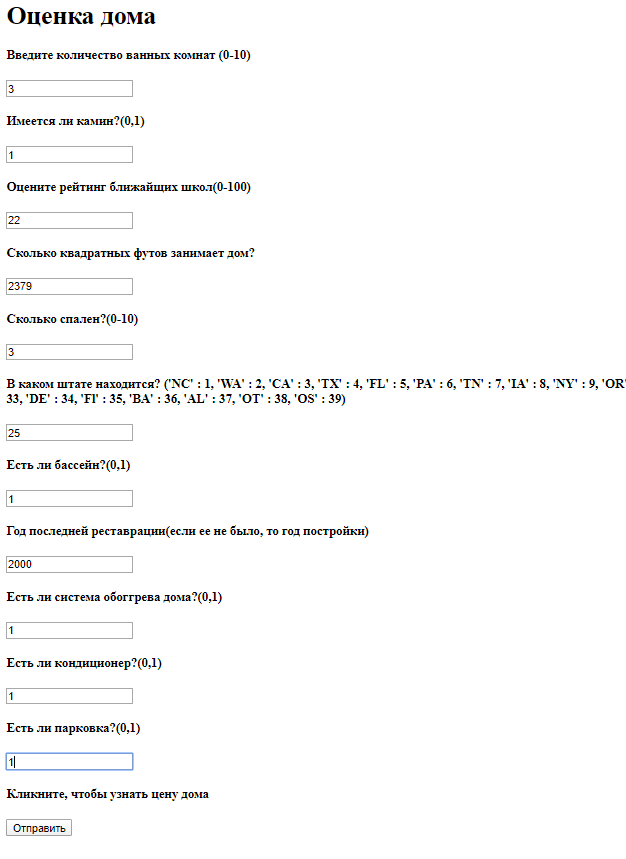

При нажатии на кнопку, показывается оценка дома

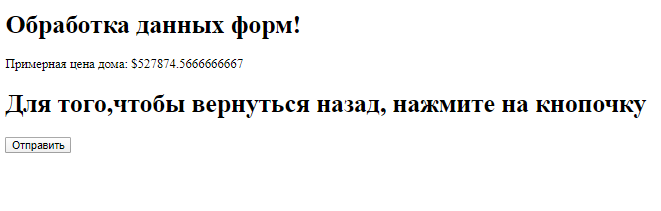